First of all we are going to install a couple of libraries needed for interacting with Hugging Face. We are going to use HuggingFace for downloading a pretrained model and a dataset we will use for fine-tunning it.

- Lighting: PyTorch Lighting will provide a high-level interface for PyTorch, a popular machine learning framework.
- Datasets: A library for interacting with uploaded datasets available on the Hugging Face Hub.
- Transformers: A library for interacting with pre-trained models available on the Hugging Face Hub.

In [2]:
# !pip uninstall pigments

In [3]:
# !pip install lightning
# !pip install pigments
# !pip install transformers==4.23.1
# !pip install datasets==2.6.1
# !pip install huggingface-hub==0.11.1
!pip install pytorch-lightning datasets transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!python -V

Python 3.11.12


In [5]:
# This is necessary only if we want our model to be uploaded into the hugging-face hub
# !huggingface-cli login

In [6]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 43.7 MB/s eta 0:00:00


In [7]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection


In [8]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

import random
def xyxy_to_xcycwh(box):
    """
    Boxes in images may have the format (x1, y1, x2, y2) and we may need the format (center of x, center of y, width, height).
    :param box: Tensor-like box with format (x1, y1, x2, y2)
    :return: Tensor-like box with format (center of x, center of y, width, height)
    """
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    """
    Boxes in images may have the format (center of x, center of y, width, height) and we may need the format (x1, y1, x2, y2).
    :param box: Tensor-like box with format (center of x, center of y, width, height)
    :return: Tensor-like box with format (x1, y1, x2, y2)
    """
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [9]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    """
    Boxes information contains values between 0 and 1 instead of values in pixels. This is made in order to make the boxes independant from the size of the image. But we may need to re-escale the box.
    """
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

## Downloading and visualizing the fashionpedia dataset

In [10]:
# 95% Percent of the dataset will be used for training
train_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=0, to=95, unit="%", rounding="pct1_dropremainder"))
# 5% of the dataset will be used for validation
val_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=95, to=100, unit="%", rounding="pct1_dropremainder"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [11]:
cats = train_dataset.features['objects'].feature['category']
cats

def idx_to_text(indexes):
    """
    Converts an index into a category label.
    :param indexes: List of indexes
    :return: List of category labels
    """
    labels = []
    for i in indexes:
        labels.append(cats.names[i])
    return labels

In [12]:
train_dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 43320
})

In [13]:
val_dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 2280
})

Plotting random item 26339


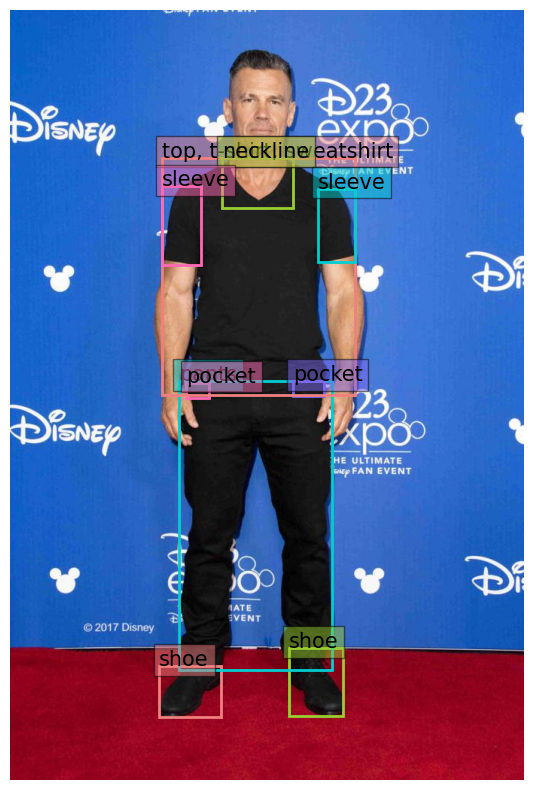

In [14]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

### Preprocessing our dataset

In [15]:
# In order to use our images for the training, we're going to preprocess them, it is possible to use the YOLOs preprocessor.
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [16]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [17]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)

In [18]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [19]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 43320
Number of validation examples: 2280


In [20]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [21]:
item = next(iter(train_dataloader))

In [22]:
item

{'pixel_values': tensor([[[[-0.2856, -0.3541, -0.5767,  ...,  0.1254,  0.2282,  0.2282],
           [-0.1143, -0.2684, -0.3541,  ...,  0.2111,  0.2967,  0.2282],
           [-0.0287, -0.3027, -0.3369,  ..., -0.1657, -0.0629, -0.1143],
           ...,
           [ 1.8893,  1.9064,  1.9407,  ...,  2.2147,  2.2318,  2.2318],
           [ 1.9578,  1.9920,  2.0263,  ...,  2.1633,  2.2318,  2.2489],
           [ 2.0092,  2.0434,  2.1119,  ...,  2.0434,  2.1975,  2.2489]],
 
          [[-0.1625, -0.2325, -0.4601,  ...,  0.2752,  0.3803,  0.3803],
           [ 0.0126, -0.1450, -0.2325,  ...,  0.3627,  0.4503,  0.3803],
           [ 0.0826, -0.1800, -0.2325,  ..., -0.0224,  0.0826,  0.0301],
           ...,
           [ 1.5882,  1.6057,  1.6232,  ...,  2.2185,  2.2360,  2.2360],
           [ 1.6057,  1.6232,  1.6758,  ...,  2.1310,  2.2185,  2.2185],
           [ 1.6057,  1.6583,  1.7283,  ...,  2.0084,  2.1660,  2.2360]],
 
          [[-0.4275, -0.4798, -0.6890,  ...,  0.2173,  0.3219,  0.3219

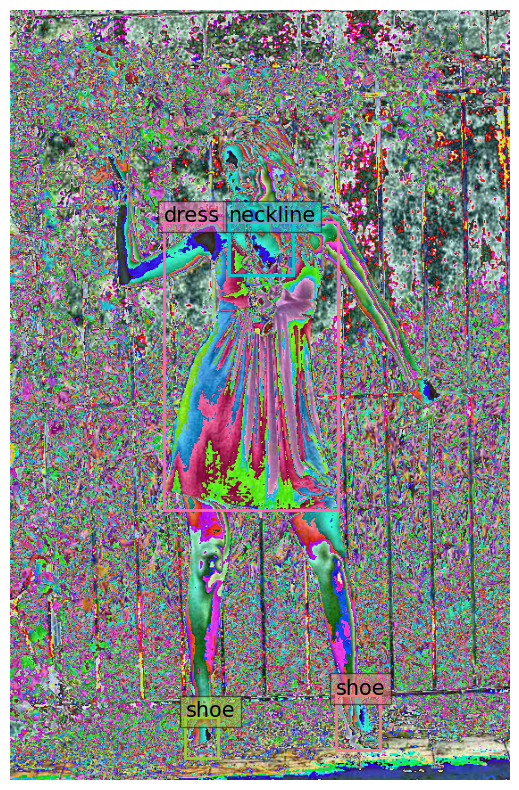

In [23]:
random_i = random.randint(0, BATCH_SIZE-1)
random_i = 0
pil_image = transforms.ToPILImage()(item['pixel_values'][random_i])
class_labels = item['labels'][random_i]['class_labels']
size = pil_image.size
boxes = rescale_bboxes(cxcywh_to_xyxy(item['labels'][random_i]['boxes']), size, down=False)
plot_results(pil_image, boxes, idx_to_text(class_labels.tolist()))

In [24]:
class Detr(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                                  num_labels=cats.num_classes,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [25]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([47, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

Detr(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosAttention(
              (attention): YolosSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
  

In [27]:
trainer = Trainer(max_epochs=1, accelerator="gpu", devices=1)
trainer.fit(model)

MisconfigurationException: No supported gpu backend found!

In [ ]:
model

In [ ]:
# model.model.push_to_hub("yolos-fashionpedia")

In [ ]:
# Save entire LightningModule (includes YOLOS model + config)
torch.save(model.state_dict(), "detr_lightning_weights.pth")


In [ ]:
model.model.save_pretrained("saved_yolos_model")


That's it!

In [ ]:
model = Detr(lr=1e-4, weight_decay=1e-4)
model.load_state_dict(torch.load("detr_lightning_weights.pth"))
model.eval()


In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("saved_yolos_model")
model.eval()


In [ ]:
import torch
dummy_input = torch.randn(1, 3, 640, 640)  # example input shape
torch.onnx.export(model.model,               # Hugging Face model
                  dummy_input,
                  "yolos_model.onnx",
                  opset_version=11,
                  input_names=["pixel_values"],
                  output_names=["output"])
